In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

In [2]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[7])
y_data

,FE n-PrOH
0,0.000000
1,0.000000
2,1.501805
3,0.000000
4,0.000000
...,...
77,0.000000
78,0.581841
79,0.000000
80,0.000000


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) 
variate=list(range(x_train.shape[1]))   
selected=[]   
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  

    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)


while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  
        current_variate = selected+[i]   
        current_x_train = x_train[:, current_variate]   
        current_x_test = x_test[:, current_variate]   
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  
    selected.append(best_candidate_index) 
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])


In [21]:
selected

[106,
 196,
 306,
 30,
 257,
 140,
 112,
 187,
 303,
 14,
 305,
 24,
 178,
 3,
 68,
 32,
 249,
 115,
 176,
 7,
 101,
 54,
 0,
 145,
 1,
 180,
 2,
 4,
 183,
 6,
 275,
 273,
 241,
 48,
 102,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 250,
 49,
 119,
 19,
 21,
 46,
 28,
 69,
 27,
 217,
 156,
 75,
 216,
 58,
 118,
 130,
 143,
 51,
 50,
 57,
 17,
 153,
 139,
 146,
 92,
 304,
 167,
 91,
 134,
 262,
 98,
 59,
 258,
 271,
 164,
 281,
 38,
 227,
 263,
 259,
 135,
 181,
 126,
 254,
 52,
 148,
 218,
 295,
 190,
 138,
 67,
 299,
 163,
 99,
 240,
 296,
 108,
 124,
 125,
 107,
 233,
 270,
 122,
 219,
 261,
 297,
 268,
 246,
 198,
 123,
 166,
 161,
 96,
 144,
 162,
 66,
 226,
 81,
 87,
 31,
 169,
 76,
 234,
 80,
 103,
 127,
 224,
 298,
 272,
 82,
 22,
 23,
 279,
 237,
 188,
 84,
 221,
 236,
 232,
 244,
 113,
 276,
 170,
 252,
 149,
 255,
 12,
 300,
 277,
 184,
 302,
 278,
 253,
 235,
 93,
 45,
 151,
 301,
 157,
 282,
 79,
 150,
 129,

In [15]:
train_mse_list

[0.046277656751833554,
 0.0401190728201838,
 0.03780835662144086,
 0.025664531846366283,
 0.0254475218550745,
 0.024608951438459446,
 0.024098265614005764,
 0.02429693188558647,
 0.024534759472214535,
 0.025534668308806165,
 0.025780324724389708,
 0.026698259228436688,
 0.02524741717651092,
 0.024603136283204062,
 0.02371370542899643,
 0.024422708633887763,
 0.024975438449796918,
 0.025098078366678905,
 0.02503147680336551,
 0.020723848064065083,
 0.019441505899590723,
 0.020007919970492335,
 0.02030575329682276,
 0.02041973592312487,
 0.020685751841468418,
 0.02090066801625453,
 0.021096387596938874,
 0.021259983130495912,
 0.021392037786368664,
 0.021518169040533823,
 0.02115032841607631,
 0.020109237274809063,
 0.020324074666485836,
 0.02059300023152382,
 0.020682029274905256,
 0.020783436407694672,
 0.020873580458824835,
 0.020953799246535343,
 0.021032101797200685,
 0.021109619117745927,
 0.02117869191772786,
 0.021242714705390086,
 0.021306368135838468,
 0.021360495331562167,
 0.

In [16]:
val_mse_list

[0.05714201631498287,
 0.0556571412352323,
 0.05703356416350354,
 0.04154383218908771,
 0.03885622391773445,
 0.037366640623238974,
 0.03718084218193081,
 0.03748344769481401,
 0.037769937872812846,
 0.03939875639744341,
 0.04148291080762912,
 0.043260669831689115,
 0.043575232392992845,
 0.04326118242685719,
 0.042407875858551,
 0.041709562335708085,
 0.04157966788656315,
 0.04149920756412776,
 0.04149407047398885,
 0.04147040824520381,
 0.04137189853341079,
 0.04094788435176261,
 0.04095990117522049,
 0.04097539614588302,
 0.0410085516661569,
 0.04104893185294549,
 0.041101882514520474,
 0.04113658579367057,
 0.041158285121544506,
 0.041243093861019035,
 0.041273930331973345,
 0.040899372575965154,
 0.04072535591441668,
 0.04053939805897813,
 0.040562392901508294,
 0.04058718792868937,
 0.040594082642128076,
 0.04062599527378833,
 0.04065212634067575,
 0.040664880177446266,
 0.040674952889199964,
 0.04070612932649297,
 0.040739623462724577,
 0.040749393008277526,
 0.04077679619200615

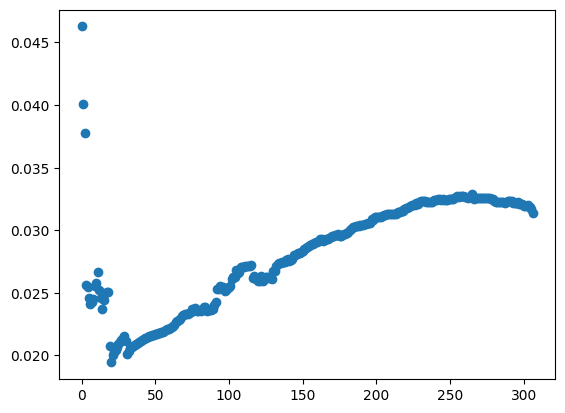

In [17]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

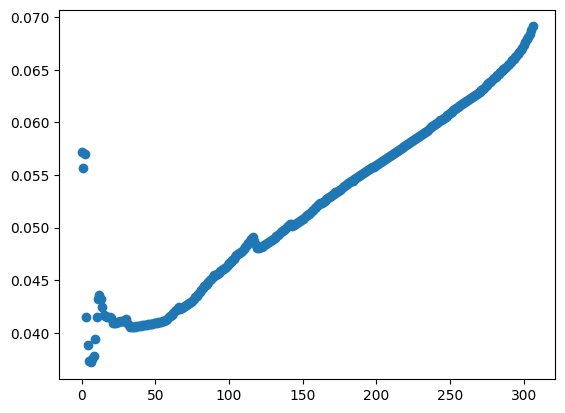

In [18]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

6
0.03718084218193081


In [9]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

PEOE_VSA8
Atom_LogP_Delta
Iaverage / mA cm-2
Alkylthiol
HOMO-LUMO Gap
VSA_EState10
SMR_VSA4


In [23]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
import os

save_dir = 'Selected features'
os.makedirs(save_dir, exist_ok=True)  
data = x_data[selected_columns]
output_file = os.path.join(save_dir, "selected_features-n-PrOH.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,PEOE_VSA8,Atom_LogP_Delta,Iaverage / mA cm-2,Alkylthiol,HOMO-LUMO Gap,VSA_EState10,SMR_VSA4
0,4.776499,1.1680,142.333333,0,0.174695,1.099537,0.0
1,0.000000,0.7226,133.000000,0,0.208260,4.994213,0.0
2,0.000000,0.9375,134.666667,1,0.250731,3.415895,0.0
3,11.505707,0.9375,107.333333,0,0.205044,0.000000,0.0
4,11.505707,0.8517,88.000000,0,0.210880,1.817130,0.0
...,...,...,...,...,...,...,...
77,0.000000,0.9159,85.333333,2,0.256097,8.366555,0.0
78,0.000000,0.9159,108.333333,2,0.256083,8.303644,0.0
79,0.000000,0.9159,83.666667,2,0.255729,8.137006,0.0
80,0.000000,0.9159,97.666667,2,0.255057,8.041327,0.0


In [10]:
from sklearn.metrics import mean_squared_error, r2_score

min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")

import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  
output_file1 = os.path.join(save_dir, "final_evaluation-n-PrOH.csv")

df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['PEOE_VSA8', 'Atom_LogP_Delta', 'Iaverage / mA cm-2', 'Alkylthiol', 'HOMO-LUMO Gap', 'VSA_EState10', 'SMR_VSA4']
Test MSE: 0.055
Test R2: 0.0695
Results saved to 'Test mse after svr/final_evaluation-n-PrOH.csv'
